# Compiling Datasets, Data Inspection and Data reduction

This notebook is to make sure anyone can produce the exactly same datasets used in the paper

Please see http://astronn.readthedocs.io/en/latest/quick_start.html#folder-structure-for-astronn-apogee-and-gaia-data to setup the enviroment such that astroNN can download SDSS APOGEE data to your computer and compile the dataset.

#### To make things easier, we first continuum normalize all APOGEE DR14 stellar spectra into a single file and the array ordered in a way to correspond to DR14 allstar file. Please make sure you run this before running other notebooks

In [ ]:
import numpy as np
import time
import h5py
from astropy.io import fits

from astroNN.apogee import allstar, visit_spectra
from astroNN.datasets import xmatch
from astroNN.gaia import mag_to_fakemag
from astroNN.apogee.chips import apogee_continuum, gap_delete
from astroNN.nn.losses import mean_absolute_percentage_error

target_bit = [0, 1, 2, 3, 4, 5, 6, 7, 12]
def apstar_normalization(spectra, spectra_err, _spec_mask):
    return apogee_continuum(spectra=spectra, spectra_err=spectra_err, cont_mask=None, deg=2, dr=14, bitmask=_spec_mask)

allstar_data = fits.getdata(allstar(dr=14))

start_time = time.time()

total_num = allstar_data['RA'].shape[0]
spec = np.zeros((total_num, 7514), dtype=np.float32)

for counter in range(0, total_num):
    if allstar_data['LOCATION_ID'][counter] == 1:
        continue
    ap_path = visit_spectra(dr=14, apogee=allstar_data['APOGEE_ID'][counter], 
                            location=allstar_data['LOCATION_ID'][counter], verbose=0)
    if ap_path is False:
        pass
    else:
        apstar_file = fits.open(ap_path)
        nvisits = apstar_file[0].header['NVISITS']
        if nvisits == 1:
            _spec = apstar_file[1].data
            _spec_err = apstar_file[2].data
            _spec_mask = apstar_file[3].data
        else:
            _spec = apstar_file[1].data[1]
            _spec_err = apstar_file[2].data[1]
            _spec_mask = apstar_file[3].data[1]
        
        if not np.all(_spec==0.):
            _spec, _spec_err = apstar_normalization(_spec, _spec_err, _spec_mask)
            spec[counter] = _spec

    if counter % 1000 == 0:
        print(f'Completed {counter} of {total_num}, {(time.time() - start_time):.{2}f}s elapsed')
        
# save a fits
hdu = fits.PrimaryHDU(spec)
hdu.writeto('contspec_dr14.fits')

#### Then we compile training set and testing sets

In [ ]:
from astropy.io import fits
from astroNN.apogee import allstar
from astroNN.gaia import gaiadr2_parallax, mag_to_fakemag, extinction_correction
import h5py
import numpy as np
# To load Gaia DR2 - APOGEE DR14 matches, indices corresponds to APOGEE allstar DR14 file
ra, dec, parallax, parallax_error = gaiadr2_parallax(cuts=1., keepdims=True, offset=0.05)
dontusera, dontusedec, raw_parallax, dontuseparallax_error = gaiadr2_parallax(cuts=1., keepdims=True, offset=False)

# open the file containing all continuum normalized spectra
file = fits.open("contspec_dr14.fits")
allstar_file = fits.getdata(allstar(dr=14))
all_spec = file[0].data

extinction = allstar_file['AK_TARG']
extinction[extinction<0.] = -9999.  # assume corrupted extinction if negative extinction
corrected_K = extinction_correction(allstar_file['K'], extinction)
fakemag, fakemag_error = mag_to_fakemag(corrected_K, parallax, parallax_error)

# cutting criteria
good_idx = [(parallax != -9999.) & (allstar_file['SNR'] > 200) & (fakemag > 0.) & 
            np.all(all_spec != 0., axis=1) & (allstar_file['vscatter'] < 1.) & (allstar_file['STARFLAG'] == 0)]

good_test_idx = [(parallax != -9999.) & (allstar_file['SNR'] < 200) & (fakemag > 0.) & 
                 np.all(all_spec != 0., axis=1) & (allstar_file['vscatter'] < 1.) & (allstar_file['STARFLAG'] == 0)]

print("Training Set Spectra: ", np.sum(good_idx))
print("Low SNR Combined Spectra Testing Set Spectra: ", np.sum(good_test_idx))

h5f = h5py.File('gaia_dr2_train.h5', 'w')
h5f.create_dataset('spectra', data=all_spec[good_idx])
h5f.create_dataset('RA', data=allstar_file['RA'][good_idx])
h5f.create_dataset('DEC', data=allstar_file['DEC'][good_idx])
h5f.create_dataset('SNR', data=allstar_file['SNR'][good_idx])
h5f.create_dataset('fakemag', data=fakemag[good_idx])
h5f.create_dataset('fakemag_err', data=fakemag_error[good_idx])
h5f.create_dataset('corrected_K', data=corrected_K[good_idx])  # extinction corrected
h5f.create_dataset('extinction', data=extinction[good_idx])
h5f.create_dataset('parallax', data=parallax[good_idx])
h5f.create_dataset('parallax_original', data=raw_parallax[good_idx])  # raw gaia parallax
h5f.create_dataset('parallax_err', data=parallax_error[good_idx])
h5f.close()

h5f = h5py.File('gaia_dr2_test.h5', 'w')
h5f.create_dataset('spectra', data=all_spec[good_test_idx])
h5f.create_dataset('RA', data=allstar_file['RA'][good_test_idx])
h5f.create_dataset('DEC', data=allstar_file['DEC'][good_test_idx])
h5f.create_dataset('SNR', data=allstar_file['SNR'][good_test_idx])
h5f.create_dataset('fakemag', data=fakemag[good_test_idx])
h5f.create_dataset('fakemag_err', data=fakemag_error[good_test_idx])
h5f.create_dataset('corrected_K', data=corrected_K[good_test_idx])  # extinction corrected
h5f.create_dataset('extinction', data=extinction[good_test_idx])
h5f.create_dataset('parallax', data=parallax[good_test_idx])
h5f.create_dataset('parallax_original', data=raw_parallax[good_test_idx])  # raw gaia parallax
h5f.create_dataset('parallax_err', data=parallax_error[good_test_idx])
h5f.close()

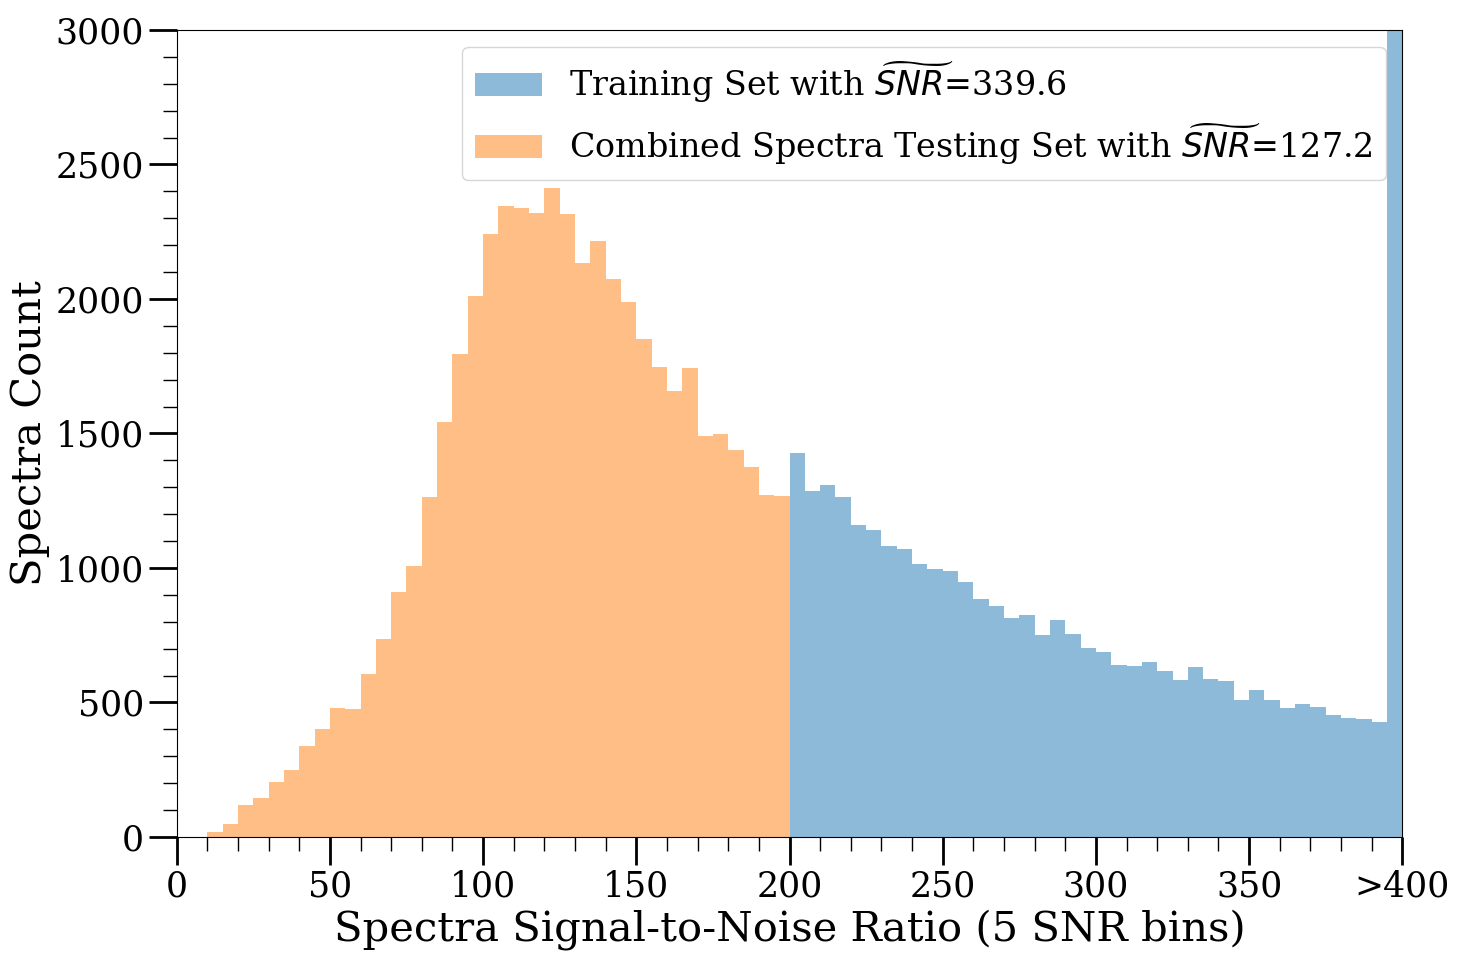

In [24]:
%matplotlib inline
import h5py
import pylab as plt
import numpy as np
from astroNN.gaia import gaiadr2_parallax

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

train_h5 = h5py.File('gaia_dr2_train.h5', 'r')
test_combined_h5 = h5py.File('gaia_dr2_test.h5', 'r')

upper_bound = 400  # if SNR higher than 400, count it as  400

train_SNR = train_h5['SNR']
test_combined_SNR = test_combined_h5['SNR']

fig = plt.figure(figsize=(15,10), dpi=100)
ax = plt.gca()
plt.hist(np.clip(train_SNR, 0, upper_bound), 80, range=(0, upper_bound), alpha=0.5, 
         label=r'Training Set with $\widetilde{SNR}$=' + f'{np.median(train_SNR):.{1}f}')
plt.hist(test_combined_SNR, 80, range=(0, upper_bound), alpha=0.5, 
         label=r'Combined Spectra Testing Set with $\widetilde{SNR}$=' + f'{np.median(test_combined_SNR):.{1}f}')
# plt.hist(parallax_snr, 40, range=(0, upper_bound), alpha=0.5, label='Individual Spectra Testing set')
plt.xlabel('Spectra Signal-to-Noise Ratio (5 SNR bins)', fontsize=30)
plt.ylabel('Spectra Count', fontsize=30)
plt.ylim((0, 3000))
plt.xlim((0, upper_bound))
plt.legend(loc='best', fontsize=24)
plt.minorticks_on()
ax.set_xticklabels(['0', '50', '100', '150', '200', '250', '300', '350', '>400'])
plt.tick_params(labelsize=25, width=2, length=20, which='major')
plt.tick_params(width=1, length=10, which='minor')
plt.tight_layout()
plt.savefig('SNR_spectra.pdf')
plt.show()

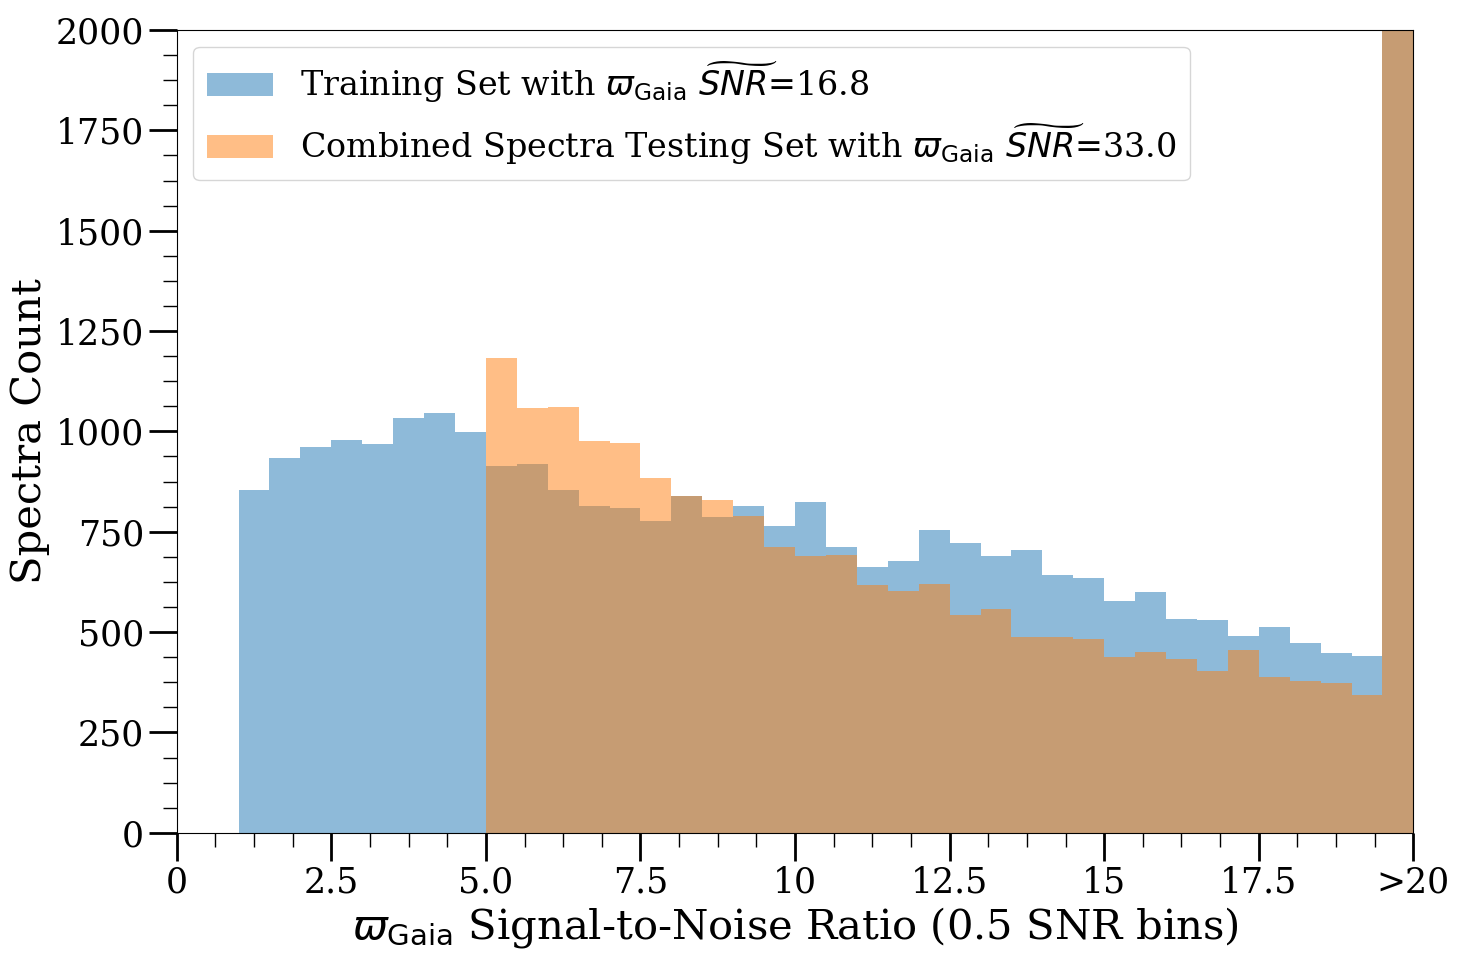

In [23]:
%matplotlib inline
import h5py
import pylab as plt
import numpy as np
from astroNN.gaia import gaiadr2_parallax

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

train_h5 = h5py.File('gaia_dr2_train.h5', 'r')
test_combined_h5 = h5py.File('gaia_dr2_test.h5', 'r')

upper_bound = 20  # if SNR higher than 400, count it as  400

train_SNR = np.array(train_h5['parallax_original']) / np.array(train_h5['parallax_err'])
test_combined_SNR = np.array(test_combined_h5['parallax_original']) / np.array(test_combined_h5['parallax_err'])

fig = plt.figure(figsize=(15,10), dpi=100)
ax = plt.gca()
plt.hist(np.clip(train_SNR, 0, upper_bound), 40, range=(0, upper_bound), alpha=0.5, 
         label=r'Training Set with $\varpi_{\mathrm{Gaia}}$ $\widetilde{SNR}$=' + 
         f'{np.median(train_SNR):.{1}f}')
plt.hist(np.clip(test_combined_SNR, 0, upper_bound), 40, range=(0, upper_bound), alpha=0.5, 
         label=r'Combined Spectra Testing Set with $\varpi_{\mathrm{Gaia}}$ $\widetilde{SNR}$=' + 
         f'{np.median(test_combined_SNR):.{1}f}')
# plt.hist(parallax_snr, 40, range=(0, upper_bound), alpha=0.5, label='Individual Spectra Testing set')
plt.xlabel(r'$ \varpi_{\mathrm{Gaia}}$' + ' Signal-to-Noise Ratio (0.5 SNR bins)', fontsize=30)
plt.ylabel('Spectra Count', fontsize=30)
plt.ylim((0, 2000))
plt.xlim((0, upper_bound))
plt.legend(loc='best', fontsize=24)
plt.minorticks_on()
ax.set_xticklabels(['0', '2.5', '5.0', '7.5', '10', '12.5', '15', '17.5', '>20'])
plt.tick_params(labelsize=25, width=2, length=20, which='major')
plt.tick_params(width=1, length=10, which='minor')
plt.tight_layout()
plt.savefig('SNR_parallax.pdf')
plt.show()

This is Gaia DR2 - APOGEE DR14 matched parallax, RA DEC in J2000, parallax in mas


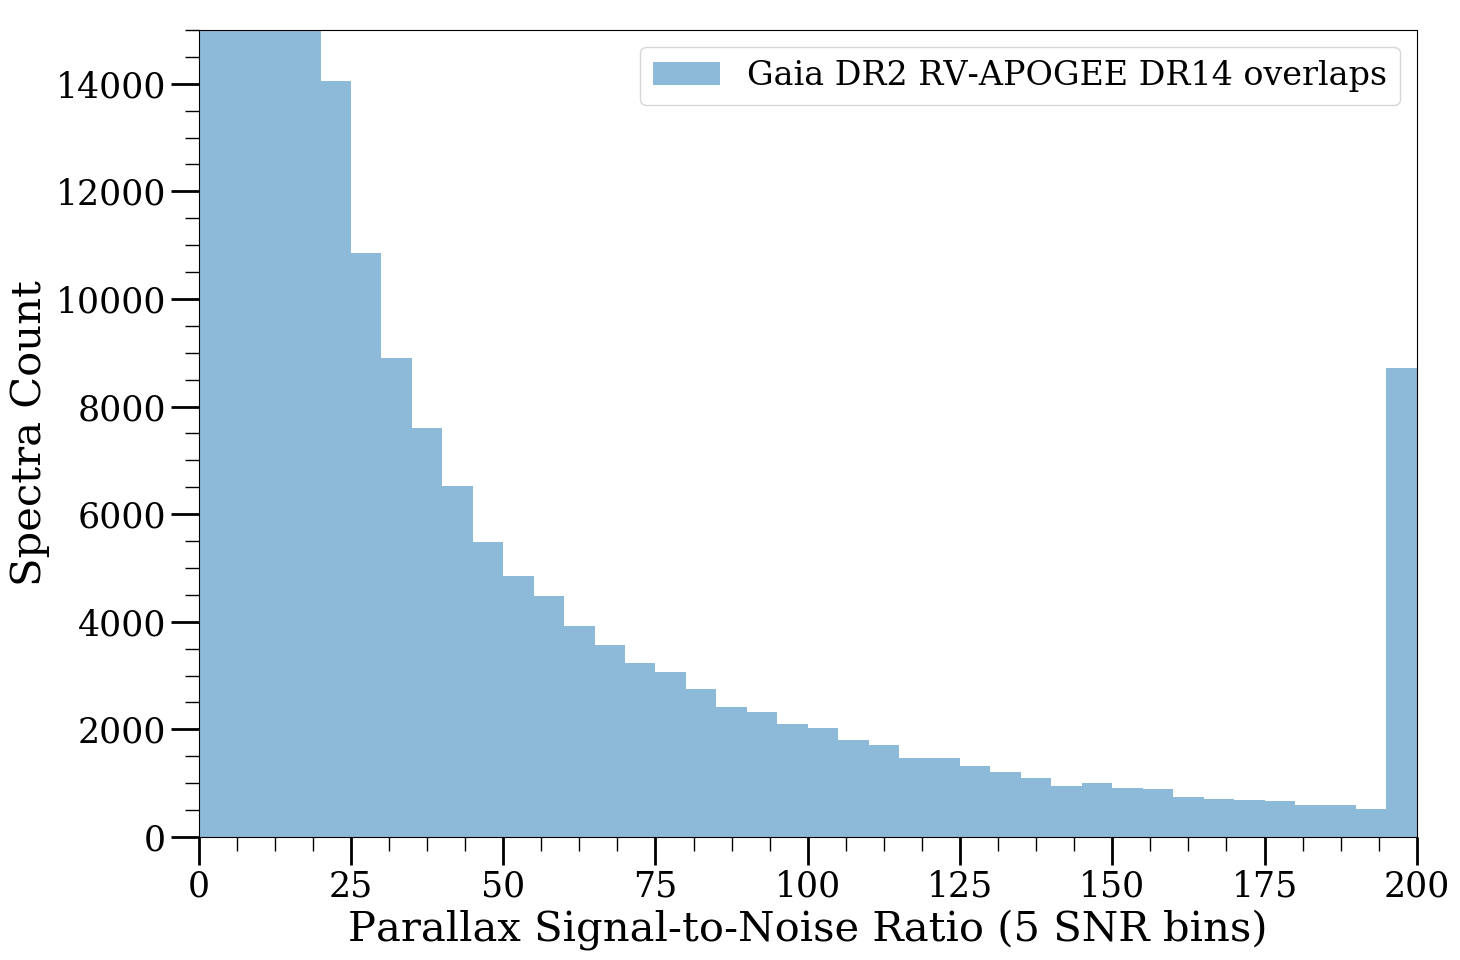

In [1]:
%matplotlib inline
import pylab as plt
import numpy as np
from astroNN.gaia import gaiadr2_parallax

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

ra, dec, parallax, parallax_error = gaiadr2_parallax(cuts=False, keepdims=False)

upper_bound = 200  # if SNR higher than 400, count it as  400
parallax_snr = parallax / parallax_error
parallax_snr[parallax_snr>upper_bound] = upper_bound

plt.figure(figsize=(15,10), dpi=100)
plt.hist(parallax_snr, 40, range=(0, upper_bound), alpha=0.5, label='Gaia DR2 RV-APOGEE DR14 overlaps')
plt.xlabel('Parallax Signal-to-Noise Ratio (5 SNR bins)', fontsize=30)
plt.ylabel('Spectra Count', fontsize=30)
plt.ylim((0, 15000))
plt.xlim((0, upper_bound))
plt.legend(loc='best', fontsize=24)
plt.minorticks_on()
plt.tick_params(labelsize=25, width=2, length=20, which='major')
plt.tick_params(width=1, length=10, which='minor')
plt.tight_layout()
plt.savefig('SNR_APOGEE_DR2RV.pdf')
plt.show()